## import lib and create function

In [1]:
import os
import gc
import math
import sklearn
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
from preprocess import *
from utils import *

## Read and preprocess data

In this part, we can optimize the model by adding more external data from other sources: crypto, stocks,... and internal data: return, volumne

In [2]:
path = '/Users/nguyenhuyhai/202224/NEST_QUANT/data/'

In [3]:
"""
optimizable
"""
# path = '/content/gdrive/MyDrive/NESTQUANT/data/'

"""
BTC data path
"""
path_BTC = path + 'BTC/BTCUSDT'
path_LABEL = path + 'BTC/SYMBOL=BTCUSDT.parquet'

"""
external data path
"""
path_ETHUSDT = path+ 'coin/ETHUSDT'
path_LTCUSDT = path+ 'coin/LTCUSDT'
path_CPILFESL = path + 'FRED/CPILFESL.parquet'
path_EURUSD = path + 'fx/C_EURUSD'
path_SPY = path+'stock/SPY'

"""
Add more external datapath in here

"""


'\nAdd more external datapath in here\n\n'

In [4]:
"""
BTC preprocessing
""" 
df_Label = pd.read_parquet(path_BTC)
df_BTC = pd.read_parquet(path_LABEL)

df_BTCLabel = df_BTC.join(df_Label, how='inner')
df_BTCLabel = df_BTCLabel.drop(columns=["YEAR_AND_MONTH","SYMBOL"])

In [5]:
"""
optimizable
"""

"""
External preprocessing
"""
df_BTCLabel = preprocess_df(df_BTCLabel, "BTC",1, 12)
df_ETHUSDT = preprocess_df(pd.read_parquet(path_ETHUSDT),"ETHUSDT", 1, 12)
df_LTCUSDT = preprocess_df(pd.read_parquet(path_LTCUSDT),"LTCUSDT",1, 12)
df_EURUSD = preprocess_df(pd.read_parquet(path_EURUSD),"EURUSD", 1, 12)
df_SPY = preprocess_df(pd.read_parquet(path_SPY),"SPY", 1, 12)
"""
add more external data with external path
"""


'\nadd more external data with external path\n'

In [6]:
df_BTCLabel = df_BTCLabel.dropna()
df_ETHUSDT = df_ETHUSDT.dropna()
df_LTCUSDT = df_LTCUSDT.dropna()
df_EURUSD = df_EURUSD.dropna()
df_SPY = df_SPY.dropna()

In [7]:
df_CPILFESL = pd.read_parquet(path_CPILFESL)
df_CPILFESL = get_dupp(df_CPILFESL)
df_CPILFESL["OPEN_TIME"] = df_CPILFESL["DATE"].apply(lambda x: int(datetime.timestamp(x)) *1000)
df_CPILFESL = df_CPILFESL.drop("DATE", axis= 1)
df_CPILFESL = df_CPILFESL.set_index("OPEN_TIME")

/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/code/preprocess.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/code/preprocess.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/code/preprocess.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/code/preprocess.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

Merge external data

In [8]:
df_BTCLabel1 = df_BTCLabel.join(df_ETHUSDT, how = 'inner')
df_BTCLabel2 = df_BTCLabel1.join(df_EURUSD, how="left").bfill().ffill()
df_BTCLabel3 = df_BTCLabel2.join(df_LTCUSDT, how="left").bfill().ffill()
df_BTCLabel4 = df_BTCLabel3.join(df_SPY, how="left").bfill().ffill()
df_BTCLabel5 = df_BTCLabel4.join(df_CPILFESL, how="left").bfill().ffill().reset_index()

Get features from dataframe, here I just only get:  "OPEN_TIME","OPEN_BTC","HIGH_LTCUSDT","LABEL_BTC","VOLABILITY_BTC_23", however, we can get moreeee

## Preprocessing data

### check corr

In [9]:
time_lst = df_BTCLabel5.OPEN_TIME.tolist()

In [15]:
delta = 24
rangee = 500
time_lst = df_BTCLabel5.OPEN_TIME.tolist()

In [ ]:
df_corr = check_cor(df_BTCLabel5, rangee, delta, time_lst, 'LABEL_BTC')

In [ ]:
df_corr[:12]["index"].tolist()

['OPEN_BTC',
 'CLOSE_BTC',
 'LOW_BTC',
 'HIGH_BTC',
 'OPEN_ETHUSDT',
 'LOW_ETHUSDT',
 'CLOSE_ETHUSDT',
 'HIGH_ETHUSDT',
 'CLOSE_LTCUSDT',
 'LOW_LTCUSDT',
 'OPEN_LTCUSDT',
 'HIGH_LTCUSDT']

### Check feature importance

In [16]:
df_feat_importance, important_tuple = check_featureImportant_slow(df_BTCLabel5, rangee, delta, time_lst, 'LABEL_BTC')

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n

In [14]:
len(important_tuple)

235

### Choosing feature

In [89]:
"""
optimizable
"""

df_BTCLabel5  = df_BTCLabel5[['OPEN_TIME','VOLABILITY_BTC_11',
 'VOLUME_EURUSD',
 'OPEN_BTC',
 'VOLABILITY_BTC_2',
 'OPEN_SPY',
 'VOLABILITY_LTCUSDT_2',
 'VOLABILITY_BTC_3',
 'VOLABILITY_ETHUSDT_2',
 'RETURN_BTC_11',
 'OPEN_LTCUSDT',
 'OPEN_ETHUSDT',
 'OPEN_EURUSD',
 'VOLABILITY_BTC_4',
 'RETURN_LTCUSDT_1',
 'VOLABILITY_BTC_10',
 'VOLABILITY_BTC_6',
 'HIGH_SPY',
 'VOLUME_SPY',
 'VOLABILITY_BTC_5',
 'RETURN_BTC_2',
 'LABEL_BTC']]

In [85]:
# df_BTCLabel5 = df_BTCLabel5.drop("OPEN_TIME", axis = 1)


## Model training

take train, test data

In [90]:
x = df_BTCLabel5.drop(['LABEL_BTC'],axis=1)
y = df_BTCLabel5["LABEL_BTC"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.047, shuffle=False)


In [91]:
time_train = x_train.OPEN_TIME.tolist()

Training

In [109]:
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [110]:
"""
optimizable
"""
delta = 200 

start_training_OPEN_TIME = 500
model_predicted_scores = []
models = []
t = 0
blockPrint()

for i in range(start_training_OPEN_TIME, len(time_train), delta):
    t+=1
    tmp_train_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time_train[i-start_training_OPEN_TIME])&(df_BTCLabel5.OPEN_TIME < time_train[i-delta])]
    x_trainn = tmp_train_df.drop(['LABEL_BTC','OPEN_TIME'],axis=1)
    y_trainn = tmp_train_df["LABEL_BTC"]

    tmp_valid_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time_train[i-delta])&(df_BTCLabel5.OPEN_TIME < time_train[i])]
    x_validd = tmp_valid_df.drop(['LABEL_BTC','OPEN_TIME'],axis=1)
    y_validd = tmp_valid_df["LABEL_BTC"]

    train_data = lgb.Dataset(x_trainn, label=pd.DataFrame(y_trainn), params={'verbose': -1})
    valid_data = lgb.Dataset(pd.DataFrame(x_validd), label=pd.DataFrame(y_validd), params={'verbose': -1}, reference=train_data)

    """
    optimizable
    """

    param = { 
        'boosting_type': 'goss',
        'max_depth': 4,
        'num_leaves': 15,
        'learning_rate': 0.08,
        'objective': "regression",
        'early_stopping_rounds': 64,
        'metric': 'mse',
        'num_boost_round': 100,
        'num_iterations': 256
    #     'bagging_fraction': 0.8
    }
    if  t == 1:
      model = lgb.train(
        param,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        verbose_eval=False)
    else:
      model = lgb.train(
          param,
          train_data,
          valid_sets=[train_data, valid_data],
          valid_names=['train', 'valid'],
          verbose_eval=False,
          init_model = models[-1])

    #model_predicted_scores.append([(model.predict(x_trainn)-y_trainn).abs().mean(), (model.predict(x_validd)-y_validd).abs().mean(), (model.predict(x_testt)-y_testt).abs().mean()])

    models.append(model)



/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `n

In [111]:
len(model.dump_model()["tree_info"])

10795

### Predicting

In [94]:
pred=model.predict(x_test.drop("OPEN_TIME", axis = 1))
submit=pd.DataFrame(columns=['OPEN_TIME','PREDICTION'])
submit['OPEN_TIME']=x_test["OPEN_TIME"]
submit['PREDICTION']=pred.flatten()

testt=pd.DataFrame(columns=['TEST','PREDICTION'])

testt['TEST']=y_test
testt['PREDICTION']=pred.flatten()


In [95]:
testt

,TEST,PREDICTION
45101,0.418685,0.213202
45102,0.424813,0.258838
45103,0.431807,0.286957
45104,0.430808,0.041975
45105,0.438924,0.069231
...,...,...
47321,0.448246,0.224919
47322,0.470401,0.264007
47323,0.468764,0.306901
47324,0.474988,0.268737


In [96]:
testt.corr()

,TEST,PREDICTION
TEST,1.000000,0.178984
PREDICTION,0.178984,1.000000


In [22]:
pwd

'/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/code'

In [47]:
cd '/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/data_submit/'

/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/data_submit


In [49]:
submit.to_csv("range_500_delta_200_top15feat.csv")

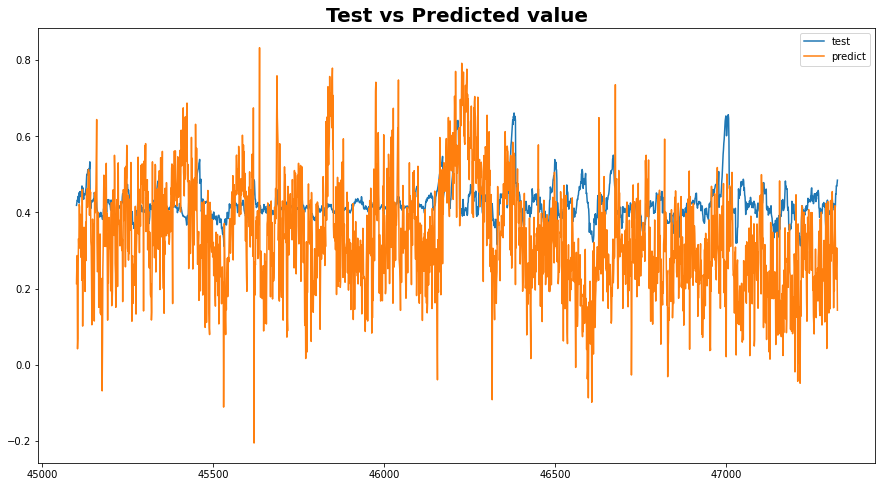

In [97]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(testt)
plt.legend(['test','predict'])


In [107]:
feat_imp = pd.DataFrame([model.feature_name(), model.feature_importance()]).T
feat_imp.columns=['Name', 'Feature Importance']
# feat = feat_imp.sort_values("Feature Importance", ascending=False)

In [108]:
feat

,Name,Feature Importance
11,OPEN_EURUSD,2758
2,OPEN_BTC,2712
8,RETURN_BTC_11,2647
9,OPEN_LTCUSDT,2545
0,VOLABILITY_BTC_11,2543
10,OPEN_ETHUSDT,2476
1,VOLUME_EURUSD,2378
4,OPEN_SPY,1855
14,VOLABILITY_BTC_10,1853
19,RETURN_BTC_2,1796


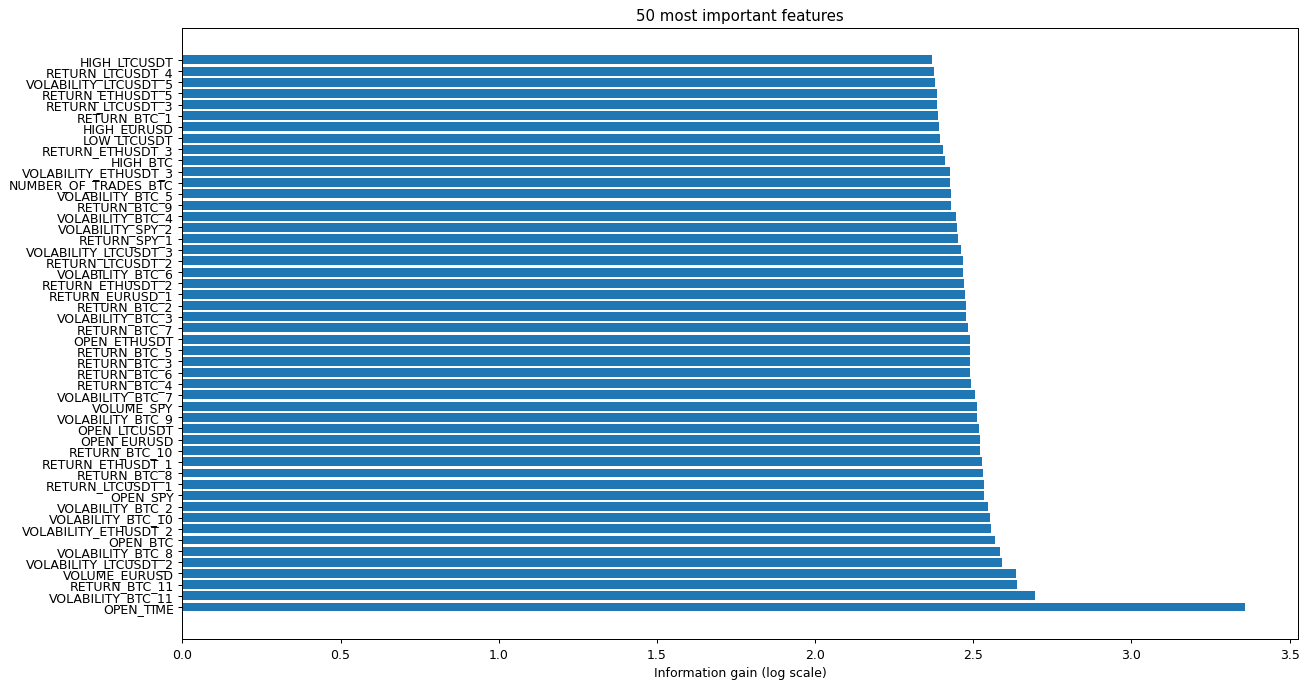

In [29]:
plot_feat_imp = feat_imp.sort_values("Feature Importance", ascending=False).iloc[:50,:]

def cal_log(x):
    return np.log10(x)

plt.figure(figsize=(16,9), dpi=90)
plt.title("50 most important features")
plt.barh(plot_feat_imp["Name"],plot_feat_imp["Feature Importance"].apply(cal_log))
plt.xlabel("Information gain (log scale)")
plt.show()

In [53]:
x_test

,OPEN_TIME,OPEN_BTC,HIGH_BTC,LOW_BTC,CLOSE_BTC,VOLUME_BTC,QUOTE_ASSET_VOLUME_BTC,NUMBER_OF_TRADES_BTC,TAKER_BUY_BASE_ASSET_VOLUME_BTC,TAKER_BUY_QUOTE_ASSET_VOLUME_BTC,...,VOLABILITY_SPY_7,RETURN_SPY_8,VOLABILITY_SPY_8,RETURN_SPY_9,VOLABILITY_SPY_9,RETURN_SPY_10,VOLABILITY_SPY_10,RETURN_SPY_11,VOLABILITY_SPY_11,VALUE
45101,1.669619e+12,16213.36,16214.75,16199.36,16203.82,722.03057,1.170118e+07,17453,319.84979,5.183694e+06,...,3.317423,-0.005859,3.113300,-0.005859,2.942393,-0.005909,2.793360,-0.006157,2.655964,300.974
45102,1.669622e+12,16224.14,16234.95,16208.17,16209.30,663.35133,1.075994e+07,16711,302.77310,4.911296e+06,...,3.317423,-0.005859,3.113300,-0.005859,2.942393,-0.005909,2.793360,-0.006157,2.655964,300.974
45103,1.669626e+12,16235.26,16248.00,16229.72,16242.79,665.00240,1.080000e+07,16230,352.05576,5.717713e+06,...,3.317423,-0.005859,3.113300,-0.005859,2.942393,-0.005909,2.793360,-0.006157,2.655964,300.974
45104,1.669630e+12,16218.07,16220.71,16180.00,16192.11,1174.22402,1.901752e+07,25699,540.52315,8.754132e+06,...,1.119332,-0.003532,1.036556,-0.003657,0.985899,-0.002981,1.094931,-0.003107,1.042488,300.974
45105,1.669633e+12,16197.21,16218.99,16190.97,16216.08,777.07747,1.259441e+07,18671,454.68961,7.369423e+06,...,0.688336,-0.000075,0.641622,0.000426,0.665081,0.000677,0.636323,0.000702,0.604057,300.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47321,1.677611e+12,23481.63,23492.84,23472.24,23473.37,634.81084,1.490652e+07,27420,298.29132,7.004613e+06,...,0.208216,-0.000160,0.199003,0.000489,0.431097,0.000276,0.432343,0.000075,0.427316,305.240
47322,1.677614e+12,23263.38,23272.46,23167.15,23189.26,2865.91452,6.652689e+07,66824,1252.80413,2.908068e+07,...,0.918417,-0.002349,0.856137,-0.002111,0.856705,-0.002688,0.828825,-0.002638,0.803418,305.240
47323,1.677618e+12,23270.59,23277.98,23192.12,23209.65,1829.57503,4.252433e+07,57949,867.87520,2.017225e+07,...,1.810048,-0.003379,1.676171,-0.003857,1.568216,-0.004071,1.482781,-0.004297,1.409569,305.240
47324,1.677622e+12,23138.89,23173.84,23094.69,23164.41,1371.82450,3.173706e+07,40889,703.06152,1.626665e+07,...,0.452967,0.000278,0.421669,0.000328,0.394551,0.000531,0.383953,-0.000051,0.503161,305.240


In [35]:
path_model = '/content/gdrive/MyDrive/NESTQUANT/models/'
model.save_model(path_model+"UpdatedBestmodel.txt")